# Notebook 21: Empirical relations

While the IGIMF shown in Notebook 20 is a function of metallicity and SFR, for our purposes we would like to treat it as a function of metallicity and redshift. Obsevations have indicated the existence of certain empirical relations between galactic parameters that connect the SFR to the redshift. For us, these relations are the **Star Formation-Mass Relation** (SFMR), the **Mass-Metallicity Relation** (MZR) and the **Fundamental Metallicity Relation** (FMR). Here we will treat the employed models for the SFMR and the MZR, and how it is one option to solve them analitically for the SFR as a function of metallicity in a limited region of the parameter space. The FMR is taken into account in Notebook 32.

## Prelude

In [1]:
import numpy as np
import astropy.constants as ct
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import interp1d
from scipy.optimize import fsolve, curve_fit
from astropy.cosmology import WMAP9 as cosmo

import sys
sys.path.append('../src/')
from constants import ZOH_SUN
from utils import FeH_to_OFe, FeH_from_ZOH, ZOH_to_FeH

In [2]:
LN10 = np.log(10)
LOGE = np.log10(np.e)

## Star Formation-Mass Relation

Following Chruslinska et al. (2019) we include three options of SFMR. These are by Boogaard et al. (2018), Speagle et al. (2014) and Tomczak et al. (2016) and we refer to them as the Boogard, Speagle and Tomczak SFMRs. For each option we define a low and a high mass range. In the low mass range, the Boogard SFMR is always applied, while for the high mass range either the Boogard, Speagle or Tomczak SFMR is applied, according to the option made. This leads to different amounts of flattening of the relation in the high mass range: Boogard is a "no flattening" option, Speagle "moderate flattening" and Tomczak "sharp flattening".

In [3]:
def a_boogard():
    return 0.83

def b_boogard(z):
    if z <= 1.8:
        return c_boogard(z) * np.log10(1+z) - 8.2
    else:
        return c_boogard(z) * np.log10(1+z) - 8.2 + 1.8*np.log10(2.8)

def c_boogard(z):
    if z <= 1.8:
        return 2.8
    else:
        return 1
    
def BoogaardSFMR(z, M):
    return (a_boogard()*np.log10(M)+b_boogard(z))

In [4]:
def a_speagle(t):
    return 0.84 - 0.026*t/1e9

def SpeagleSFMR(z, M):
    t = cosmo.age(z).value*1e9
    b = BoogaardSFMR(z, 10**9.7)-a_speagle(t)*np.log10(10**9.7)
    if np.log10(M) >= 9.7:
        return (a_speagle(t)*np.log10(M)+b)
    else:
        return BoogaardSFMR(z, M)

In [5]:
class Tomczak:
    
    def __init__(self, redshift):
        self.redshift = redshift
        self._s0 = None
        self._logMTO = None
        self._gamma = None
        self._yshift = None
        self._yshift_logM = None
    
    def _logMTOfunc(self, redshift):
        return 9.458 + 0.865*redshift - 0.132*redshift**2
    
    def _f(self, x):
        if x<8 or x>11:
            return 10
        dx = x - self.logMTO
        a = 0.83
        return  np.abs(a*(1+10**(self.gamma*dx)) - self.gamma)
    
    def set_yshift(self):
        self._yshift_logM = fsolve(self._f, self.redshift/9+9)
        self._yshift = BoogaardSFMR(self.redshift, 10**self._yshift_logM) - self.SFMR(self._yshift_logM)
    
    @property
    def s0(self):
        if self._s0 is None:
            self._s0 = 0.448 + 1.220*self.redshift - 0.174*self.redshift**2
        return self._s0
    
    @property
    def logMTO(self):
        if self._logMTO is None:
            if self.redshift < 0.5:
                self._logMTO = self._logMTOfunc(0.5)
            elif self.redshift > 3.28:
                self._logMTO = self._logMTOfunc(3.28)
            else:
                self._logMTO = self._logMTOfunc(self.redshift)
        return self._logMTO
    
    @property
    def gamma(self):
        if self._gamma is None:
            self._gamma = 1.091
        return self._gamma

    def SFMR(self, logMstar):
        if self._yshift_logM is None:
            print('Please run set_yshift first.')
            return
        elif self._yshift is None:
            exp10 = 10 ** (-self.gamma * (logMstar-self.logMTO))
            return self.s0 - np.log10(1+exp10)
        else:
            if logMstar < self._yshift_logM:
                return BoogaardSFMR(self.redshift, 10**logMstar)
            else:
                exp10 = 10 ** (-self.gamma * (logMstar-self.logMTO))
                return self.s0 - np.log10(1+exp10) + self._yshift

In [6]:
SFMR_Ms = np.logspace(5, 13, 50)
SFMR_zs = np.arange(0.01,11,1)

In [7]:
SFMRs_boogaard = []
SFMRs_speagle = []
SFMRs_tomczak = []

for z in SFMR_zs:
    sfmr_boogaard = BoogaardSFMR(z, SFMR_Ms)
    sfmr_speagle = [SpeagleSFMR(z, m) for m in SFMR_Ms]
    sfmr_tomczak = Tomczak(z)
    sfmr_tomczak.set_yshift()
    sfmr_tomczak = [sfmr_tomczak.SFMR(np.log10(m)) for m in SFMR_Ms]
    SFMRs_boogaard.append(sfmr_boogaard)
    SFMRs_speagle.append(sfmr_speagle)
    SFMRs_tomczak.append(sfmr_tomczak)

SFMRs_boogard = np.array(SFMRs_boogaard)
SFMRs_speagle = np.array(SFMRs_speagle)
SFMRs_tomczak = np.array(SFMRs_tomczak)

/tmp/ipykernel_66938/2943934495.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  SFMRs_tomczak = np.array(SFMRs_tomczak)


Text(0.4, -0.04, '$\\log\\left(M_\\ast/\\mathrm{M}_\\odot\\right)$')

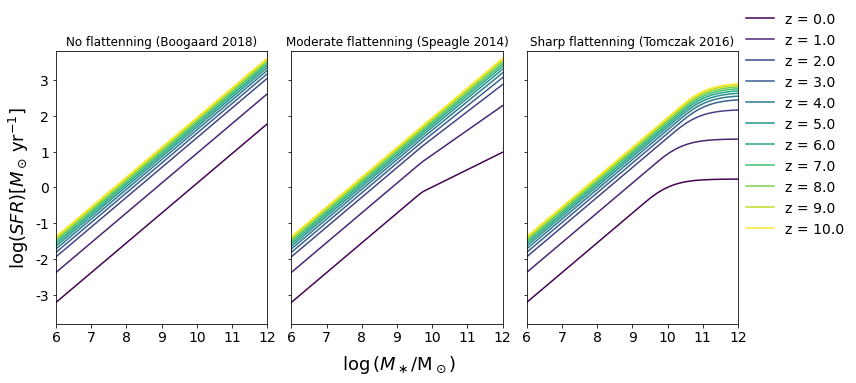

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12,5), sharey='row', tight_layout=True)
color_norm = max(SFMR_zs) - min(SFMR_zs)

for i, z in enumerate(SFMR_zs):
    axes[0].plot(SFMR_Ms, SFMRs_boogard[i], '-', c=cm.viridis((z-min(SFMR_zs))/color_norm))
    axes[1].plot(SFMR_Ms, SFMRs_speagle[i], '-', c=cm.viridis((z-min(SFMR_zs))/color_norm))
    axes[2].plot(SFMR_Ms, SFMRs_tomczak[i], '-', c=cm.viridis((z-min(SFMR_zs))/color_norm), label=f'z = {z:.1f}')
    
for ax in axes:
    ax.set_xscale('log')
    ax.set_xlim(1e6,1e12)
    ax.set_xticks(np.logspace(6,12,7))
    ax.set_xticklabels([int(np.log10(ten)) for ten in np.logspace(6,12,7)])
    ax.set_yticks(np.arange(-4,4,1))
    ax.set_yticklabels([str(x) for x in np.arange(-4,4,1)])
    ax.tick_params(axis='both', labelsize=14)
    
axes[0].set_ylabel(r'$\log(SFR)[M_\odot\,\mathrm{yr}^{-1}]$', fontsize=18)
axes[0].set_ylim(-3.8, 3.8)
axes[2].legend(loc=(1.01, 0.3), fontsize=14, frameon=False)

axes[0].set_title('No flattenning (Boogaard 2018)')
axes[1].set_title('Moderate flattenning (Speagle 2014)')
axes[2].set_title('Sharp flattenning (Tomczak 2016)')

fig.text(0.4, -0.04, r'$\log\left(M_\ast/\mathrm{M}_\odot\right)$', fontsize=18)

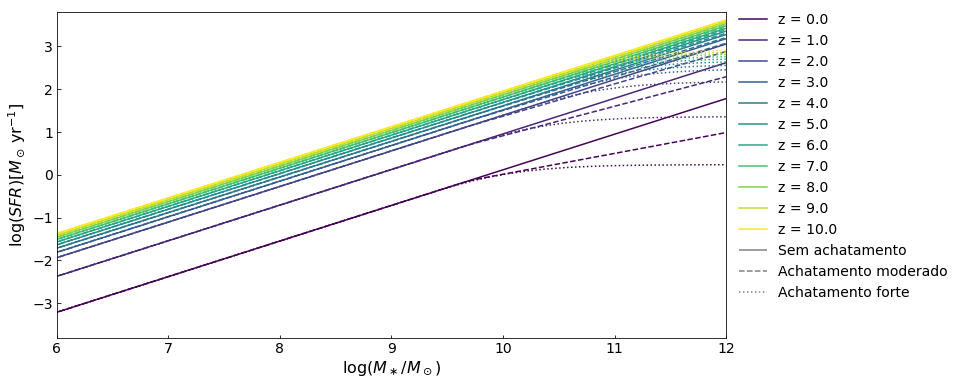

In [9]:
fig, ax = plt.subplots(figsize=(12,6))
color_norm = max(SFMR_zs) - min(SFMR_zs)

for i, z in enumerate(SFMR_zs):
    ax.plot(SFMR_Ms, SFMRs_boogard[i], '-', c=cm.viridis((z-min(SFMR_zs))/color_norm), label=f'z = {z:.1f}', alpha=1)
    ax.plot(SFMR_Ms, SFMRs_speagle[i], '--', c=cm.viridis((z-min(SFMR_zs))/color_norm), alpha=1)
    ax.plot(SFMR_Ms, SFMRs_tomczak[i], ':', c=cm.viridis((z-min(SFMR_zs))/color_norm))

ax.set_xscale('log')

ax.set_xlabel(r'$\log(M_\ast/M_\odot)$', fontsize=16)
ax.set_ylabel(r'$\log(SFR)[M_\odot\,\mathrm{yr}^{-1}]$', fontsize=16)
ax.set_ylim(-3.8, 3.8)
ax.set_xlim(1e6,1e12)

ax.set_xticks(np.logspace(6,12,7))
ax.set_xticklabels([int(np.log10(ten)) for ten in np.logspace(6,12,7)])

ax.tick_params(axis='both', direction='in', labelsize=14)
ax.set_xticks([], minor=True)

ax.vlines(5, -3, -2, linestyle='-', color='gray', label='Sem achatamento')
ax.vlines(5, -3, -2, linestyle='--', color='gray', label='Achatamento moderado')
ax.vlines(5, -3, -2, linestyle=':', color='gray', label='Achatamento forte')

ax.legend(fontsize=14, frameon=False, loc=(1.01, 0.1))

plt.savefig('sfrm_models.png')

An important point must be made: in order to compute the total stellar mass of a galaxy, Chruslinska et al. (2019) assume a constant star formation history so that $M_\mathrm{tot}=\mathrm{SFR}\cdot\Delta t$, with $\Delta t=10^7 \mathrm{yr}$. On the other hand, the SFRM establishes a direct relation between the SFR and $M_\mathrm{tot}$. As seen below, the constant SFH estimate severely underestimates $M_\mathrm{tot}$.

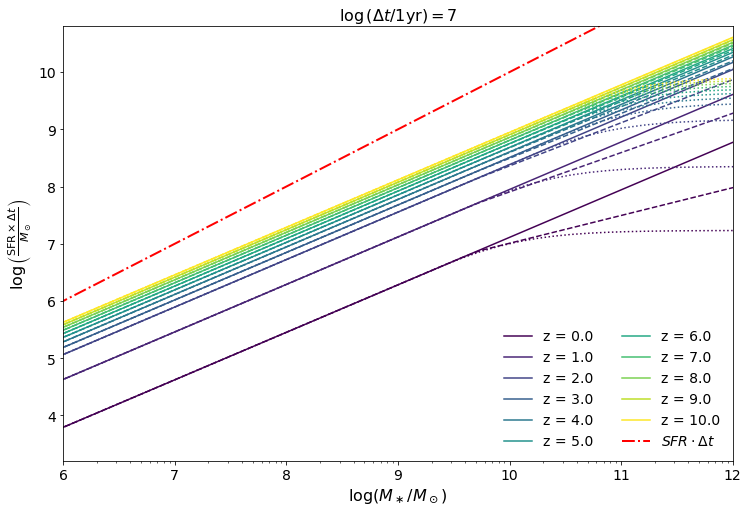

In [10]:
fig, ax = plt.subplots(figsize=(12,8))
color_norm = max(SFMR_zs) - min(SFMR_zs)
log_delta_t = 7

for i, z in enumerate(SFMR_zs):
    ax.plot(SFMR_Ms, SFMRs_boogard[i]+log_delta_t, '-', c=cm.viridis((z-min(SFMR_zs))/color_norm), label=f'z = {z:.1f}', alpha=1)
    ax.plot(SFMR_Ms, SFMRs_speagle[i]+log_delta_t, '--', c=cm.viridis((z-min(SFMR_zs))/color_norm), alpha=1)
    ax.plot(SFMR_Ms, SFMRs_tomczak[i]+log_delta_t, ':', c=cm.viridis((z-min(SFMR_zs))/color_norm))
ax.plot(SFMR_Ms, np.log10(SFMR_Ms), '-.', c='red', lw=2, label='$SFR\cdot\Delta t$')

ax.set_xscale('log')

ax.set_title(r'$\log\left(\Delta t/1\mathrm{yr}\right)=%.0f$' % log_delta_t, fontsize=16)
ax.set_xlabel(r'$\log(M_\ast/M_\odot)$', fontsize=16)
ax.set_ylabel(r'$\log\left(\frac{\mathrm{SFR}\times\Delta t}{M_\odot}\right)$', fontsize=16)
ax.set_ylim(-3.8+log_delta_t, 3.8+log_delta_t)
ax.set_xlim(1e6,1e12)

ax.set_xticks(np.logspace(6,12,7))
ax.set_xticklabels([int(np.log10(ten)) for ten in np.logspace(6,12,7)])

ax.tick_params(axis='both', labelsize=14)

ax.legend(loc='lower right', fontsize=14, frameon=False, ncol=2)

However, as stated in Chruslinska et al. (2019), the SFRM in principle should also be corrected for the non-universal IMF, but it isn't because it's only being employed as a way of connecting the SFR and the metallicity through the SFRM and the MZR. Thus, the mass given by the SFMR is not necessarily a better estimate than the estimated one. The total stellar mass of interest is also the mass formed within one star formation period, and not the total stellar mass of the galaxy, which would include the mass from other star formation periods. For that reason, we chose to keep the $\mathrm{SFR}\cdot\Delta t$ estimate.

## Mass-Metallicity Relation

Unlike the SFRM, the MZR is given as a function with empirically fitted parameters for only four values of redshift (0.01, 0.7, 2.2, 3.5), which are shown below.

In [11]:
def MZR_gen(logM, Z_a, logM_TO, gamma):
    M = 10**logM
    M_TO = 10**logM_TO
    return Z_a - np.log10(1+(M/M_TO)**-gamma)

In [12]:
def MZR_z00(M):
    return MZR_gen(M, 9.12, 9.39, 0.66)

def MZR_z07(M):
    return MZR_gen(M, 9.15, 9.86, 0.61)

def MZR_z22(M):
    return MZR_gen(M, 9.07, 10.59, 0.62)

def MZR_z35(M):
    return MZR_gen(M, 8.70, 10.67, 0.62)

In [13]:
zs = np.array([0, 0.7, 2.2, 3.5])[::-1]
Ms = np.linspace(5, 13, 50) #powers of ten

In [14]:
ZOHs = np.array([MZR_z00(Ms), MZR_z07(Ms), MZR_z22(Ms), MZR_z35(Ms)])[::-1]

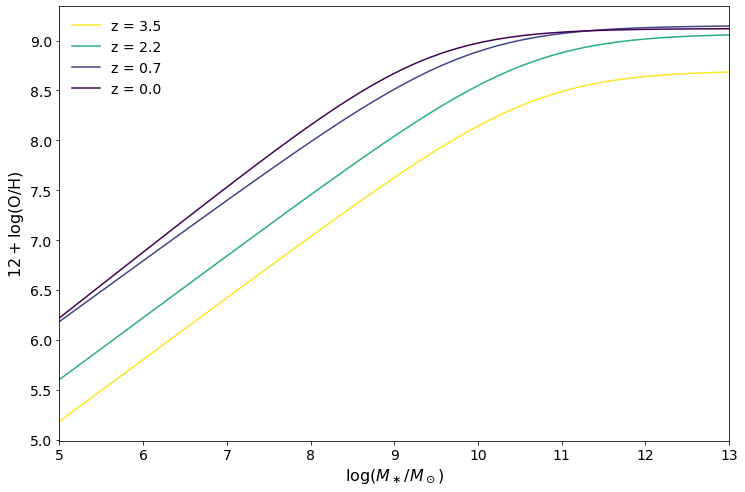

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
color_norm = max(zs) - min(zs)

for i, z in enumerate(zs):
    ax.plot(Ms, ZOHs[i], '-', c=cm.viridis((z-min(zs))/color_norm), label=f'z = {z}')

ax.set_xlim(5, 13)

ax.set_xlabel(r'$\log(M_\ast/M_\odot)$', fontsize=16)
ax.set_ylabel(r'$12+\log(\mathrm{O/H})$', fontsize=16)

ax.set_xticks(np.linspace(5,13,9))
ax.set_xticks([], minor=True)
ax.set_xticklabels([int(ten) for ten in np.linspace(5,13,9)])

ax.tick_params(axis='both', labelsize=14)

ax.legend(fontsize=14, frameon=False)

In order to be employed at any other redshift, we interpolate between these four to the desired redshift.

In [16]:
interpolX = []
interpolY = []

for i in range(ZOHs.shape[1]):
    interpolX.append(zs)
    interpolY.append(ZOHs[:,i])
    
interpolX = np.array(interpolX)
interpolY = np.array(interpolY)

Text(0, 0.5, '$12+\\log(\\mathrm{O/H})$')

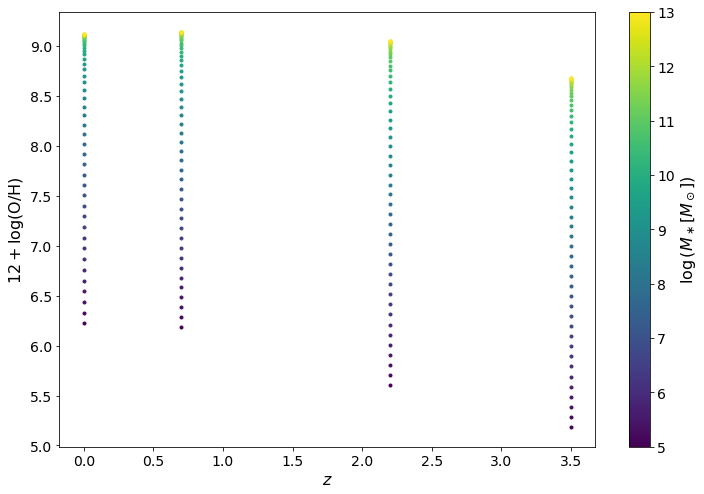

In [17]:
fig, ax = plt.subplots(figsize=(12,8))
color_norm = max(Ms) - min(Ms)

for i, M in enumerate(Ms):
    ax.plot(interpolX[i], interpolY[i], '.', c=cm.viridis((M-min(Ms))/color_norm))

sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=min(Ms), vmax=max(Ms)))
cb = fig.colorbar(sm)

cb.set_label(label=r'$\log\left(M_\ast[M_\odot]\right)$', size=16)
cb.ax.tick_params(labelsize=14)

ax.tick_params(axis='both', labelsize=14)
    
ax.set_xlabel(r'$z$', fontsize=16)
ax.set_ylabel(r'$12+\log(\mathrm{O/H})$', fontsize=16)

In [18]:
sampleinterpolX = interpolX[np.arange(0,len(interpolX),5)]
sampleinterpolY = interpolY[np.arange(0,len(interpolX),5)]
sampleMs = Ms[np.arange(0,len(interpolX),5)]

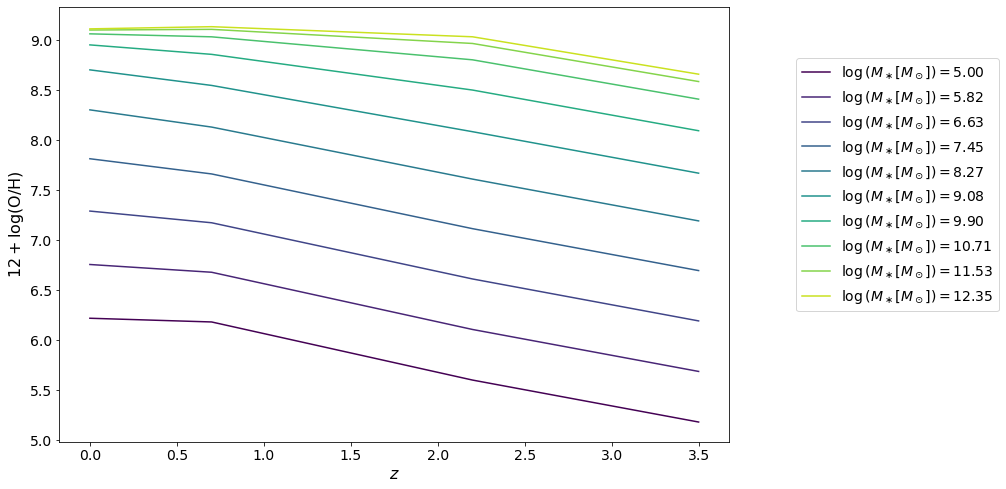

In [19]:
fig, ax = plt.subplots(figsize=(12,8))
color_norm = max(Ms) - min(Ms)

for i, M in enumerate(sampleMs):
    ax.plot(sampleinterpolX[i], sampleinterpolY[i], '-', c=cm.viridis((M-min(Ms))/color_norm), label=r'$\log\left(M_\ast[M_\odot]\right)=%.2f$'%M)
    
ax.tick_params(axis='both', labelsize=14)
    
ax.set_xlabel(r'$z$', fontsize=16)
ax.set_ylabel(r'$12+\log(\mathrm{O/H})$', fontsize=16)

ax.legend(loc=(1.1, 0.3), fontsize=14)

In [20]:
interpoledX = []
interpoledY = []

for i in range(len(interpolX)):
    f = interp1d(interpolX[i], interpolY[i], kind='cubic')
    interpoledx = np.linspace(0, 3.5, 10)
    interpoledy = f(interpoledx)
    
    interpoledX.append(interpoledx)
    interpoledY.append(interpoledy)
    
interpoledX = np.array(interpoledX)
interpoledY = np.array(interpoledY)

Text(0, 0.5, '$12+\\log(\\mathrm{O/H})$')

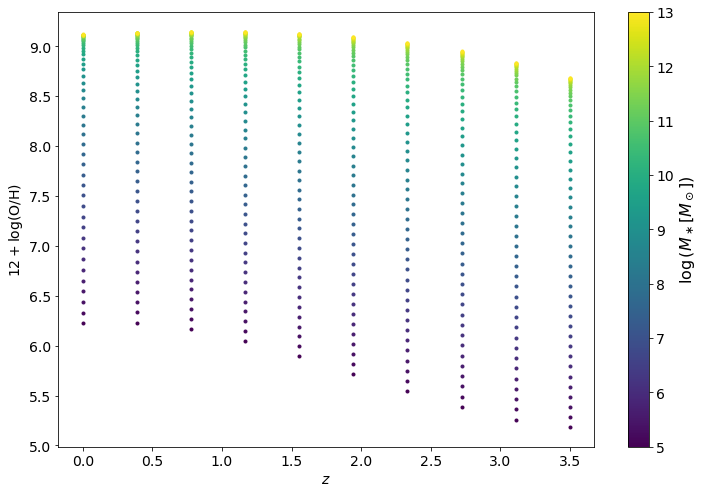

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
color_norm = max(Ms) - min(Ms)

for i, M in enumerate(Ms):
    ax.plot(interpoledX[i], interpoledY[i], '.', c=cm.viridis((M-min(Ms))/color_norm))
    
sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=min(Ms), vmax=max(Ms)))
cb = fig.colorbar(sm)

cb.set_label(label=r'$\log\left(M_\ast[M_\odot]\right)$', size=16)
cb.ax.tick_params(labelsize=14)
    
ax.tick_params(axis='both', labelsize=14)
    
ax.set_xlabel(r'$z$', fontsize=14)
ax.set_ylabel(r'$12+\log(\mathrm{O/H})$', fontsize=14)

In [22]:
sampleinterpoledX = interpoledX[np.arange(0,len(interpoledX),5)]
sampleinterpoledY = interpoledY[np.arange(0,len(interpoledX),5)]
sampleMs = Ms[np.arange(0,len(interpolX),5)]

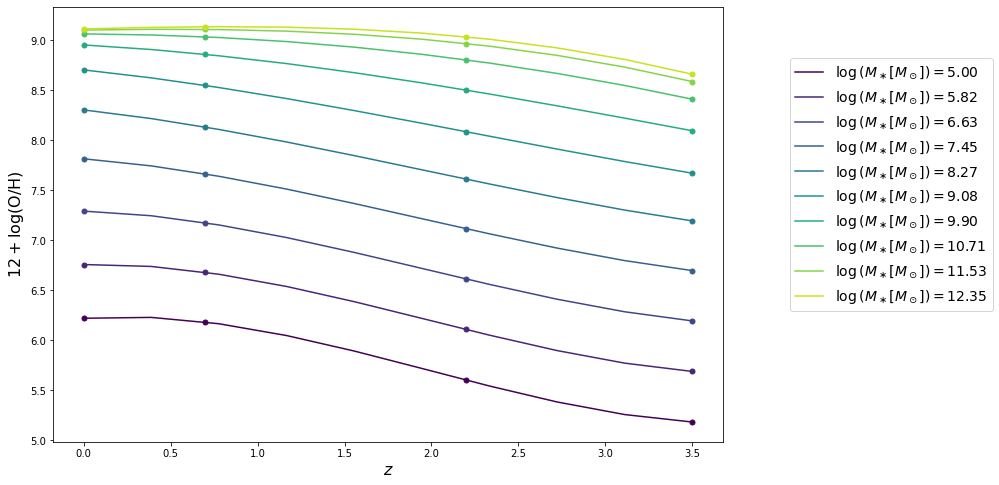

In [23]:
fig, ax = plt.subplots(figsize=(12,8))
color_norm = max(Ms) - min(Ms)

for i,M in enumerate(sampleMs):
    ax.plot(sampleinterpolX[i], sampleinterpolY[i], '.', markersize=10, c=cm.viridis((M-min(Ms))/color_norm))
    ax.plot(sampleinterpoledX[i], sampleinterpoledY[i], '-', c=cm.viridis((M-min(Ms))/color_norm), label=r'$\log\left(M_\ast[M_\odot]\right)=%.2f$'%M)
    
ax.set_xlabel(r'$z$', fontsize=16)
ax.set_ylabel(r'$12+\log(\mathrm{O/H})$', fontsize=16)

ax.legend(loc=(1.1, 0.3), fontsize=14)

In [24]:
ipZOHs = []
ipzs = []

for i in range(len(interpoledX[0])):
    z = interpoledX[:,i][0]
    zohs = [zoh for zoh in interpoledY[:,i]]
    ipzs.append(z)
    ipZOHs.append(zohs)

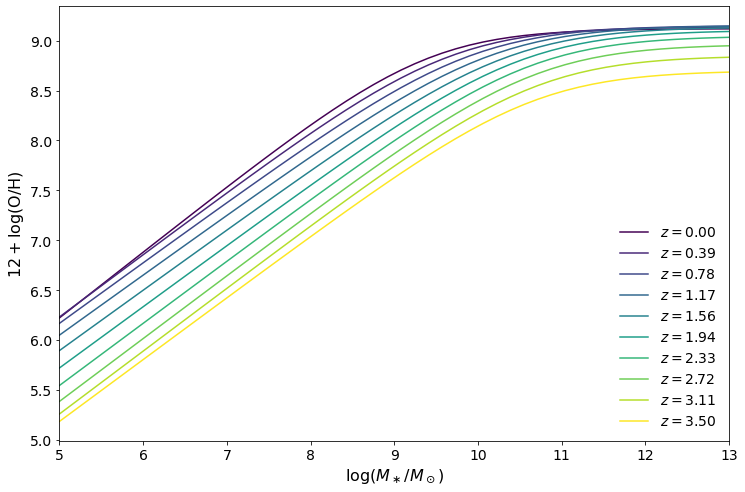

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))
color_norm = max(ipzs) - min(ipzs)

for i, z in enumerate(ipzs):
    ax.plot(Ms, ipZOHs[i], '-', c=cm.viridis((z-min(ipzs))/color_norm), label=r'$z=%.2f$'%z)
    ax.set_xlim(5,13)

ax.set_xlabel(r'$\log(M_\ast/M_\odot)$', fontsize=16)
ax.set_ylabel(r'$12+\log(\mathrm{O/H})$', fontsize=16)

ax.tick_params(axis='both', labelsize=14)

ax.legend(fontsize=14, frameon=False, loc='lower right')

In [26]:
ipFeHs = []
for i in range(len(ipZOHs)):
    feh = [ZOH_to_FeH(zoh) for zoh in ipZOHs[i]]
    ipFeHs.append(feh)

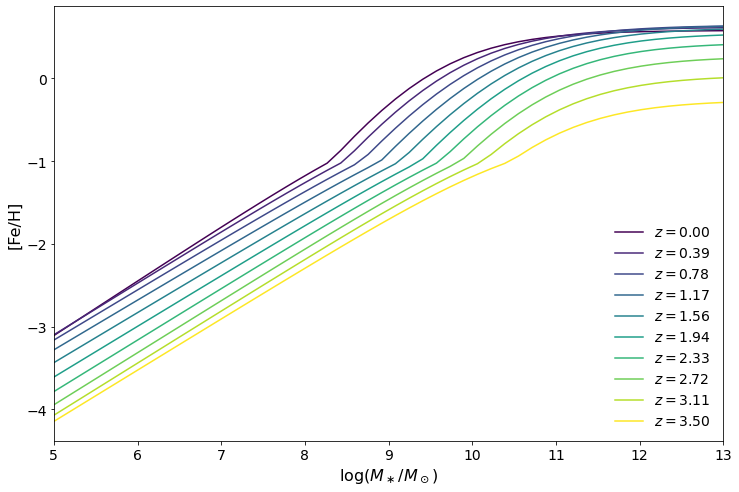

In [27]:
fig, ax = plt.subplots(figsize=(12, 8))
color_norm = max(ipzs) - min(ipzs)

for i, z in enumerate(ipzs):
    ax.plot(Ms, ipFeHs[i], '-', c=cm.viridis((z-min(ipzs))/color_norm), label=r'$z=%.2f$'%z)

ax.set_xlim(5,13)

ax.set_xlabel(r'$\log(M_\ast/M_\odot)$', fontsize=16)
ax.set_ylabel('[Fe/H]', fontsize=16)

ax.tick_params(axis='both', labelsize=14)

ax.legend(fontsize=14, frameon=False, loc='lower right')

We will need the parameters of the MZR for each redshift in order to calculate the SFR(Z, z). To obtain them, we adjust the MZR over the interpolated points for each redshift.

In [28]:
fitted_params = []

for ZOH in ipZOHs:
    params, pcovs = curve_fit(MZR_gen, Ms, ZOH, p0=(9.15, 9.86, 0.61), bounds=(0,np.inf))
    fitted_params.append(params)

In [29]:
fitZOHs = []
for params in fitted_params:
    zohs = [zoh for zoh in MZR_gen(Ms, *params)]
    fitZOHs.append(zohs)

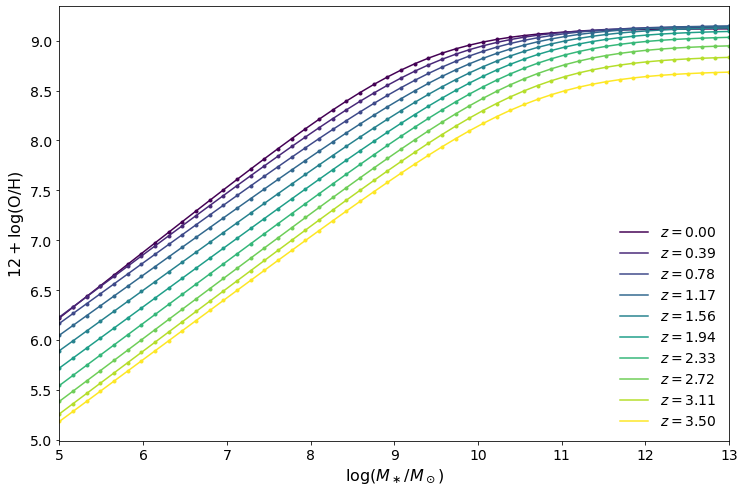

In [30]:
fig, ax = plt.subplots(figsize=(12,8))
color_norm = max(ipzs) - min(ipzs)

for i, z in enumerate(ipzs):
    ax.plot(Ms, ipZOHs[i], '.', c=cm.viridis((z-min(ipzs))/color_norm))
    ax.plot(Ms, fitZOHs[i], '-', c=cm.viridis((z-min(ipzs))/color_norm), label=r'$z=%.2f$'%z)

ax.set_xlim(5,13)
    
ax.set_xlabel(r'$\log(M_\ast/M_\odot)$', fontsize=16)
ax.set_ylabel(r'$12+\log(\mathrm{O/H})$', fontsize=16)

ax.tick_params(axis='both', labelsize=14)

ax.legend(fontsize=14, frameon=False, loc='lower right')

In [31]:
fitFeHs = []
for ZOH in fitZOHs:
    fehs = [ZOH_to_FeH(zoh) for zoh in ZOH]
    fitFeHs.append(fehs)

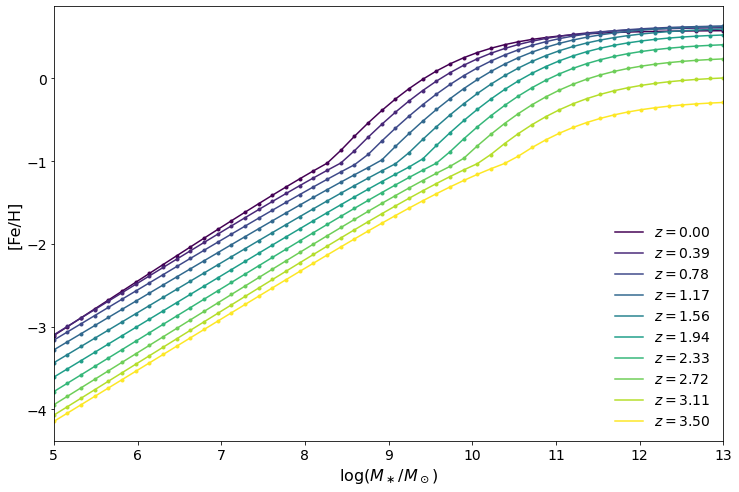

In [32]:
fig, ax = plt.subplots(figsize=(12,8))
color_norm = max(ipzs) - min(ipzs)

for i, z in enumerate(ipzs):
    ax.plot(Ms, ipFeHs[i], '.', c=cm.viridis((z-min(ipzs))/color_norm))
    ax.plot(Ms, fitFeHs[i], '-', c=cm.viridis((z-min(ipzs))/color_norm), label=r'$z=%.2f$'%z)

ax.set_xlim(5,13)
    
ax.set_xlabel(r'$\log(M_\ast/M_\odot)$', fontsize=16)
ax.set_ylabel('[Fe/H]', fontsize=16)

ax.tick_params(axis='both', labelsize=14)

ax.legend(fontsize=14, frameon=False, loc='lower right')

#### SFZR

Finally, we can solve the MZR and the SFMR for the SFR, eliminating the mass and obtaining SFR(Z, z).

In [33]:
def SFZR(ZOH, z, Z_a, logM_TO, gamma): #returns log SFR
    M_TO = 10**logM_TO
    Zexp = 10**(Z_a-ZOH)
    return b_boogard(z) - (a_boogard()/gamma) * np.log10(M_TO**-gamma * (Zexp-1))

In [34]:
SFZRs = []
SFZR_ZOHs = []
for z, params in zip(ipzs, fitted_params):
    sfzr_zohs = np.linspace(6, params[0]*0.99, 50)
    sfzrs = SFZR(sfzr_zohs, z, *params)
    SFZR_ZOHs.append(sfzr_zohs)
    SFZRs.append(sfzrs)

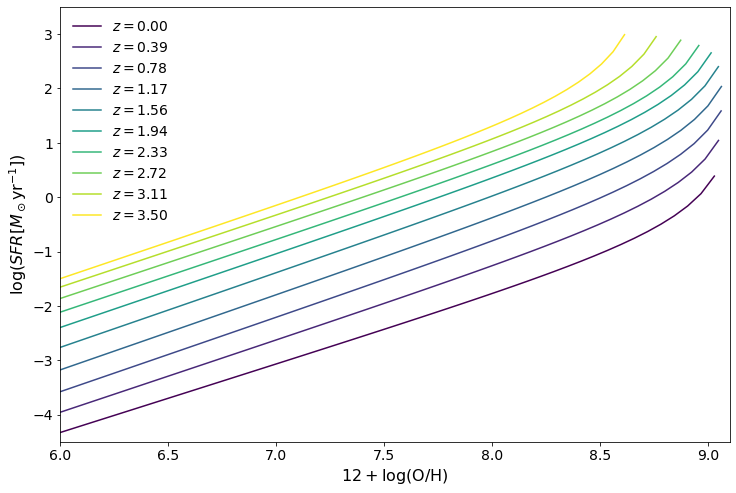

In [35]:
fig, ax = plt.subplots(figsize=(12,8))
color_norm = max(ipzs) - min(ipzs)

for i, z in enumerate(ipzs):
    ax.plot(SFZR_ZOHs[i], SFZRs[i], '-', c=cm.viridis((z-min(ipzs))/color_norm), label=r'$z=%.2f$'%z)

ax.set_xlim(6,9.1)
ax.set_ylim(-4.5, 3.5)

ax.set_ylabel(r'$\log(SFR[M_\odot\mathrm{yr}^{-1}])$', fontsize=16)
ax.set_xlabel(r'$12+\log(\mathrm{O/H})$', fontsize=16)

ax.tick_params(axis='both', labelsize=14)

ax.legend(fontsize=14, frameon=False, loc='upper left')

In [36]:
SFZR_FeHs = []

for sfzr_zohs in SFZR_ZOHs:
    sfzr_fehs = [ZOH_to_FeH(zoh) for zoh in sfzr_zohs]
    SFZR_FeHs.append(sfzr_fehs)

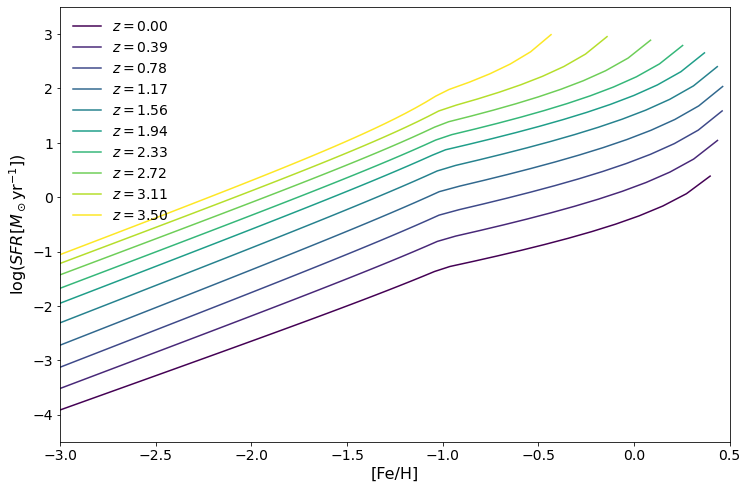

In [37]:
fig, ax = plt.subplots(figsize=(12,8))
color_norm = max(ipzs) - min(ipzs)

for i, z in enumerate(ipzs):
    ax.plot(SFZR_FeHs[i], SFZRs[i], '-', c=cm.viridis((z-min(ipzs))/color_norm), label=r'$z=%.2f$'%z)

ax.set_xlim(-3,0.5)
ax.set_ylim(-4.5,3.5)

ax.set_ylabel(r'$\log(SFR[M_\odot\mathrm{yr}^{-1}])$', fontsize=16)
ax.set_xlabel('[Fe/H]', fontsize=16)

ax.tick_params(axis='both', labelsize=14)

ax.legend(fontsize=14, frameon=False, loc='upper left')

#### Full MZR

In [38]:
import sys
sys.path.append('../src/')
from sfr import MZR

In [39]:
fmzr_zs = np.arange(0, 11, 1)
fmzr_logms = np.linspace(7, 12, 100)

In [40]:
fmzr_zohs = np.empty((0,100), np.float64)

for z in fmzr_zs:
    mzr = MZR(z, 'KK04')
    mzr.set_params()
    zohs = np.array([[mzr.zoh(logm) for logm in fmzr_logms]])
    fmzr_zohs = np.append(fmzr_zohs, zohs, axis=0)

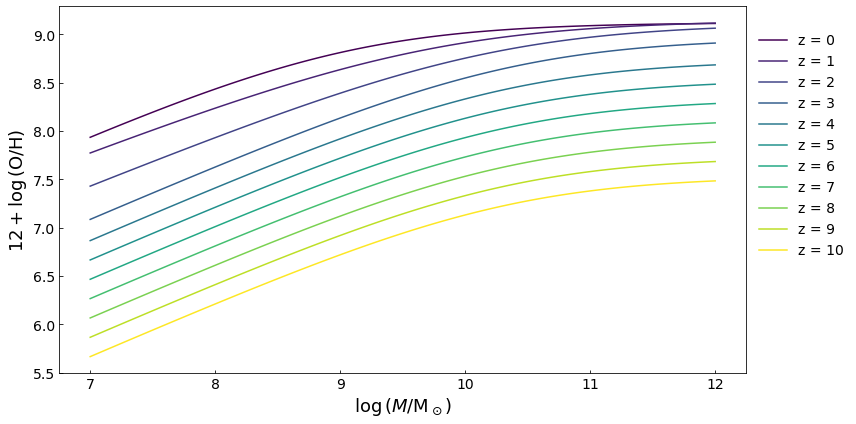

In [41]:
fig, ax = plt.subplots(figsize=(12,6), tight_layout=True)
fmzr_cnorm = fmzr_zs.max() - fmzr_zs.min()

for z, zohs in zip(fmzr_zs, fmzr_zohs):
    color = cm.viridis((z-fmzr_zs.min())/fmzr_cnorm)
    ax.plot(fmzr_logms, zohs, c=color, label=f'z = {z}')
    
ax.legend(loc=(1.01, 0.3), frameon=False, fontsize=14)

ax.set_xlabel(r'$\log\left(M/\mathrm{M}_\odot\right)$', fontsize=18)
ax.set_ylabel(r'$12+\log\left(\mathrm{O/H}\right)$', fontsize=18)
ax.tick_params(axis='both', direction='in', labelsize=14)

plt.savefig('mzrmodels.png')